In [1]:
#Based on 
# https://people.stat.sc.edu/hansont/stat740/ModelSelection.pdf?fbclid=IwAR0YFk1zPRPyUHtWsxBPvrZiN_9T5z1yolgBYKrHOmxXoisNUC-jJoWxmYE
# http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf?fbclid=IwAR0YFk1zPRPyUHtWsxBPvrZiN_9T5z1yolgBYKrHOmxXoisNUC-jJoWxmYE

In [1]:
import pystan
import numpy as np
import sklearn 
import pandas as pd


In [2]:
n = 1000

alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(n)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

#nusance variable
z= 4* np.random.rand(n)





In [3]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
    vector[N] z;
}
parameters {
    real alpha;
    real beta;
    real beta2;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x + beta2 * z, sigma);
}




"""

In [5]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y, 'z':z}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=1, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d7f2b3d8dd98bddd22808816e0d7aecf NOW.


In [6]:
fit

Inference for Stan model: anon_model_d7f2b3d8dd98bddd22808816e0d7aecf.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   4.06  3.9e-3   0.08   3.92   4.01   4.07   4.12   4.21    394    1.0
beta    0.51  5.1e-4   0.01   0.48    0.5   0.51   0.51   0.53    465    1.0
beta2  -0.04  1.3e-3   0.03  -0.09  -0.05  -0.04  -0.02   0.02    454    1.0
sigma   1.01  1.1e-3   0.02   0.97    1.0   1.01   1.03   1.06    429   1.01
lp__  -509.9    0.09   1.31 -513.3 -510.6 -509.7 -508.9 -508.2    207    1.0

Samples were drawn using NUTS at Wed Sep  9 15:48:54 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [7]:
type(fit)

stanfit4anon_model_d7f2b3d8dd98bddd22808816e0d7aecf_1987080328341055463.StanFit4Model

In [8]:
sim1 = fit.to_dataframe()
sim1

,chain,draw,warmup,alpha,beta,beta2,sigma,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,4.011501,0.505655,-0.001611,0.973964,-510.558236,0.972632,0.301362,4,15,0,513.408309
1,0,1,0,4.008361,0.505132,-0.009198,0.984605,-509.243373,0.894239,0.301362,2,7,0,511.213714
2,0,2,0,4.097469,0.506277,-0.050111,1.018018,-508.270650,0.993329,0.301362,3,15,0,509.368310
3,0,3,0,4.106868,0.503551,-0.048113,1.037503,-508.950662,0.998656,0.301362,4,15,0,509.009827
4,0,4,0,4.130073,0.490779,-0.051937,0.990403,-509.978241,0.816237,0.301362,4,15,0,514.490579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,495,0,4.134395,0.509446,-0.061170,1.036559,-509.942858,0.877984,0.301362,2,3,0,511.604052
496,0,496,0,4.048593,0.505319,-0.048197,1.003558,-508.786379,0.996188,0.301362,4,15,0,511.698918
497,0,497,0,4.058265,0.512952,-0.039263,1.017580,-508.747427,0.990846,0.301362,3,15,0,509.360384
498,0,498,0,4.125238,0.509994,-0.055641,1.010120,-509.378307,0.861943,0.301362,3,15,0,510.331866


In [9]:
post_means  = fit.get_posterior_mean()
post_means = post_means[0:len(post_means)-1]
post_means

array([[ 4.06378968],
       [ 0.50523401],
       [-0.03800017],
       [ 1.01178752]])

In [10]:
lik1 = fit.log_prob(post_means)

lik1

-1077.9387908652045

In [11]:
np.mean(sim1[['lp__']])

lp__   -509.969994
dtype: float64

In [12]:
DIC1 = 2*(lik1 - np.mean(sim1[['lp__']]))
DIC1

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


lp__   -1135.937593
dtype: float64

In [13]:
model2 = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
    vector[N] z;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x , sigma);
}




"""

In [14]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y, 'z':z }

# Compile the model
sm = pystan.StanModel(model_code=model2)

# Train the model and generate samples
fit2 = sm.sampling(data=data, iter=1000, chains=1, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ddb2ffeb4973f36a46ac6b7b7f073873 NOW.


In [15]:
fit2

Inference for Stan model: anon_model_ddb2ffeb4973f36a46ac6b7b7f073873.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    4.0  4.2e-3   0.06   3.87   3.95    4.0   4.04   4.11    204    1.0
beta     0.5  6.9e-4   0.01   0.48    0.5    0.5   0.51   0.52    250    1.0
sigma   1.01  1.3e-3   0.02   0.97   0.99   1.01   1.03   1.06    293    1.0
lp__  -510.4    0.08   1.13 -513.3 -511.0 -510.1 -509.6 -509.1    228   1.02

Samples were drawn using NUTS at Wed Sep  9 15:49:39 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [16]:
post_means  = fit2.get_posterior_mean()
post_means = post_means[0:len(post_means)-1]

post_means

array([[3.99713491],
       [0.50317854],
       [1.01130939]])

In [17]:
lik2 = fit2.log_prob(post_means)
lik2

-1077.659385798255

In [18]:
sim2 = fit2.to_dataframe()
sim2

,chain,draw,warmup,alpha,beta,sigma,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,4.034058,0.493428,0.990808,-509.897863,0.979900,0.37545,3,7,0,510.384038
1,0,1,0,4.028704,0.489461,0.992141,-510.849404,0.877564,0.37545,3,7,0,510.931743
2,0,2,0,4.004068,0.506017,0.997924,-509.400059,0.917027,0.37545,3,7,0,511.525388
3,0,3,0,4.035887,0.492648,1.022687,-509.763308,0.982189,0.37545,4,15,0,510.232175
4,0,4,0,3.946723,0.516843,0.989822,-510.264040,0.976853,0.37545,3,7,0,511.092703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,495,0,4.027954,0.494081,1.008007,-509.510058,0.777054,0.37545,2,3,0,510.928708
496,0,496,0,3.998435,0.493322,1.010072,-510.568860,0.839290,0.37545,2,7,0,510.984956
497,0,497,0,3.998435,0.493322,1.010072,-510.568860,0.671822,0.37545,1,3,0,512.372628
498,0,498,0,4.015931,0.493247,1.019368,-509.999736,0.992574,0.37545,2,7,0,511.154006


In [19]:
np.mean(sim2[['lp__']])

lp__   -510.459814
dtype: float64

In [20]:
DIC2 = 2*(lik2 - np.mean(sim2[['lp__']]))
DIC2

lp__   -1134.399144
dtype: float64

In [74]:
DIC1

lp__   -1135.937593
dtype: float64

In [75]:
DIC2

lp__   -1134.399144
dtype: float64

In [76]:
#^ The one with the higher DIC is better. 
#In this case, since model 1 had unnecessary parameters, DIC2 is better so its penalizing for parameters correctly
#it since it has a data based degrees of freedom calculation, it's valid for multiplicative models too


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a33929003e9509f9c9fbc54beac0c762 NOW.


Inference for Stan model: anon_model_a33929003e9509f9c9fbc54beac0c762.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha1    4.0  4.8e-3   0.09   3.84   3.94    4.0   4.06   4.18    337    1.0
beta1     0.5  8.2e-4   0.01   0.47   0.49    0.5   0.51   0.53    324    1.0
sigma1   1.02  1.2e-3   0.03   0.95    1.0   1.02   1.04   1.08    648    1.0
alpha2   3.98  3.9e-3   0.08   3.82   3.93   3.99   4.04   4.14    425    1.0
beta2    0.51  7.0e-4   0.01   0.48    0.5   0.51   0.52   0.54    461    1.0
sigma2   1.01  1.3e-3   0.03   0.95   0.98   1.01   1.03   1.07    702    1.0
lp__   -511.1     0.1   1.63 -515.0 -511.9 -510.8 -510.0 -508.6    247    1.0

Samples were drawn using NUTS at Wed Sep  9 16:22:38 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split c

array([[4.00113683],
       [0.49673403],
       [1.01593714],
       [3.98372349],
       [0.51258991],
       [1.00809936]])

-508.25444174494277

,chain,draw,warmup,alpha1,beta1,sigma1,alpha2,beta2,sigma2,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,4.070167,0.479644,0.979756,3.818995,0.531778,1.019212,-509.527057,0.993839,0.339827,2,7,0,511.672067
1,0,1,0,4.091176,0.496481,1.020266,3.810023,0.539210,1.074989,-509.935184,0.975337,0.339827,4,15,0,512.283114
2,0,2,0,4.035564,0.487070,1.017721,3.867564,0.538554,0.962841,-510.430236,0.918261,0.339827,3,7,0,513.406255
3,0,3,0,3.993038,0.482927,1.033366,3.857825,0.529195,0.985389,-513.086868,0.759327,0.339827,4,15,0,517.402482
4,0,4,0,4.030942,0.498570,1.037344,3.909373,0.531053,1.013648,-509.203715,1.000000,0.339827,2,3,0,513.369295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,495,0,4.142142,0.481288,1.023829,3.945561,0.514835,0.986078,-509.856794,0.883758,0.339827,4,15,0,518.490783
496,0,496,0,4.098357,0.483851,1.018869,3.983931,0.518850,0.996082,-509.325832,0.989155,0.339827,3,7,0,510.488818
497,0,497,0,4.068526,0.475670,0.986317,3.672221,0.553006,1.081344,-512.454210,0.745961,0.339827,4,15,0,514.493758
498,0,498,0,4.216921,0.476690,1.060150,3.896735,0.537281,1.072656,-514.273174,0.989612,0.339827,4,15,0,517.548668


lp__   -510.606534
dtype: float64

lp__   -510.459814
dtype: float64

-1077.659385798255

-507.7439339946402

lp__    5.725201
dtype: float64

In [52]:
## simulation GOF test

In [64]:
fit2

Inference for Stan model: anon_model_ddb2ffeb4973f36a46ac6b7b7f073873.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    4.0  4.2e-3   0.06   3.87   3.95    4.0   4.04   4.11    204    1.0
beta     0.5  6.9e-4   0.01   0.48    0.5    0.5   0.51   0.52    250    1.0
sigma   1.01  1.3e-3   0.02   0.97   0.99   1.01   1.03   1.06    293    1.0
lp__  -510.4    0.08   1.13 -513.3 -511.0 -510.1 -509.6 -509.1    228   1.02

Samples were drawn using NUTS at Wed Sep  9 15:49:39 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [66]:
post_means  = fit2.get_posterior_mean()
post_means = post_means[0:len(post_means)-1]

post_means

array([[3.99713491],
       [0.50317854],
       [1.01130939]])

In [70]:
import random

n_sim = 100
n_len = len(x)
sim_Y = np.empty([n_sim,n_len])


current_alpha = post_means[0]
current_beta = post_means[1]
current_sigma = post_means[2]


for i in range(0, n_sim):
    sim_Y[i,0] = current_alpha
    for j in range(1, n_len):
        sim_Y[i,j] = current_alpha + current_beta * sim_Y[i,j-1] + random.gauss(0, current_sigma)




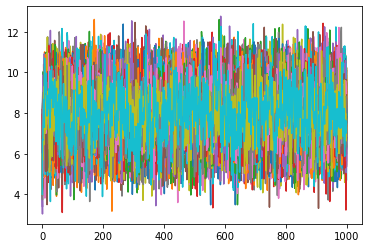

In [71]:
import matplotlib.pyplot as plt
plt.plot(sim_Y.transpose())

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-73-7440daa18e83>, line 18)